In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import logging 
import math
import vanet_tools as vp

In [3]:
df = pd.read_csv("new_york.csv",delimiter=";").dropna()
MICROCLOUD_RANGE=150

We have to check if the simulation ended with some cars still on it. The last second in the simulation as reported in the SUMO-GUI was around 4600s.

In [4]:
max_time = df['timestep_time'].max()
max_time

4468.0

Therefore, all the cars departed before the simulation finished

In [5]:
groups = df.groupby('vehicle_id')
vehicles = df['vehicle_id'].unique()
vehicle_times = [len(groups.get_group(vehicle)) for vehicle in vehicles]

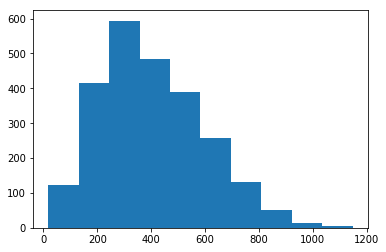

In [6]:
plt.hist(vehicle_times)
plt.show()

In [7]:
np.mean(vehicle_times)

403.09496753246754

In [8]:
simulator = vp.Simulator(df)

In [9]:
coordinates = df[['vehicle_x','vehicle_y']]

In [10]:
coords_x,coords_y = coordinates['vehicle_x'],coordinates['vehicle_y']

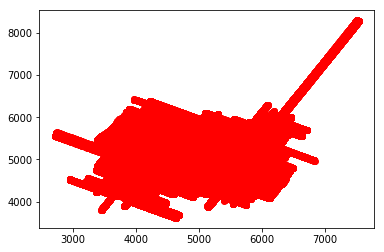

In [11]:
plt.scatter(coords_x,coords_y,c='red')
plt.show()

In [12]:
NUM_MICROCLOUDS = 100

In [13]:
microclouds_coords = vp.create_coords(coordinates,MICROCLOUD_RANGE,num_microclouds=NUM_MICROCLOUDS)

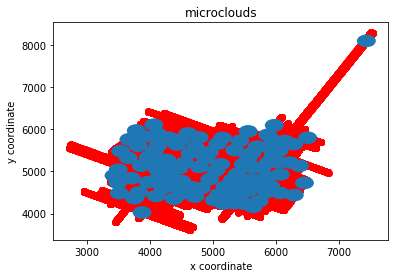

In [14]:
vp.plot_microclouds(microclouds_coords,MICROCLOUD_RANGE,coords_x,coords_y)

In [15]:
config_file = "new_york_config.csv"

In [16]:
vp.store_microcloud_config(microclouds_coords,config_file)

In [17]:
#Making sure the microclouds were stored
microclouds_coords = vp.parse_configuration(config_file)

In [18]:
TOTAL_BLOCKS = 12

In [19]:
results = simulator.simulation_by_number_of_clouds(microclouds_coords,MICROCLOUD_RANGE,step=5,total_blocks=TOTAL_BLOCKS)

INFO:root:Setting up simulation with 1 num of clouds
INFO:root:Finished setup started simulation with 1 microclouds
INFO:root:Setting up simulation with 6 num of clouds
INFO:root:Finished setup started simulation with 6 microclouds
INFO:root:Setting up simulation with 11 num of clouds
INFO:root:Finished setup started simulation with 11 microclouds
INFO:root:Setting up simulation with 16 num of clouds
INFO:root:Finished setup started simulation with 16 microclouds
INFO:root:Setting up simulation with 21 num of clouds
INFO:root:Finished setup started simulation with 21 microclouds
INFO:root:Setting up simulation with 26 num of clouds
INFO:root:Finished setup started simulation with 26 microclouds
INFO:root:Setting up simulation with 31 num of clouds
INFO:root:Finished setup started simulation with 31 microclouds
INFO:root:Setting up simulation with 36 num of clouds
INFO:root:Finished setup started simulation with 36 microclouds
INFO:root:Setting up simulation with 41 num of clouds
INFO:r

In [20]:
results_df = pd.DataFrame(results)

In [21]:
results_df

,average_files_downloaded,average_latency,block_percentage,files_downloaded,ninety_five_percentile,num_clouds
0,0.000000,NaN,0.021577,0,0.000000,1
1,0.000000,NaN,0.157265,0,0.000000,6
2,0.003653,599.111111,0.272863,9,0.000000,11
3,0.007711,603.842105,0.349229,19,0.000000,16
4,0.033279,477.414634,0.443858,82,0.000000,21
5,0.061282,456.152318,0.529458,151,0.000000,26
6,0.102679,409.438735,0.575555,253,0.000000,31
7,0.149756,372.143631,0.622903,369,0.166667,36
8,0.186688,377.915217,0.666565,460,0.250000,41
9,0.214692,373.884688,0.695312,529,0.250000,46


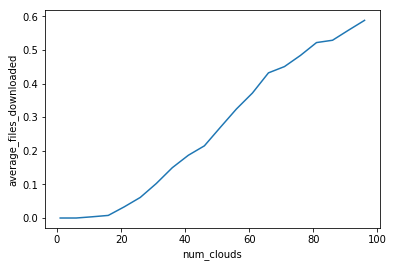

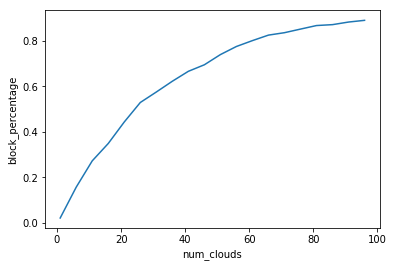

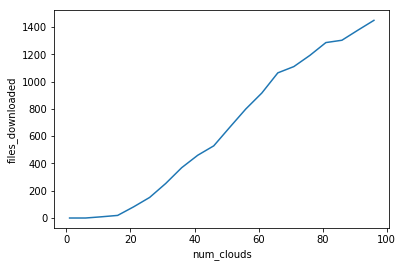

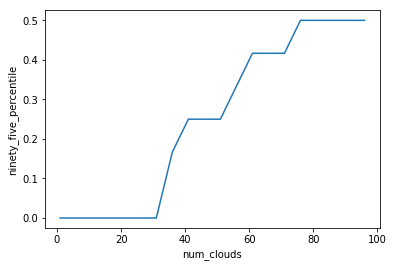

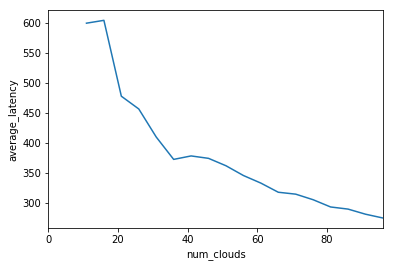

In [22]:
vp.plot_results(results_df)

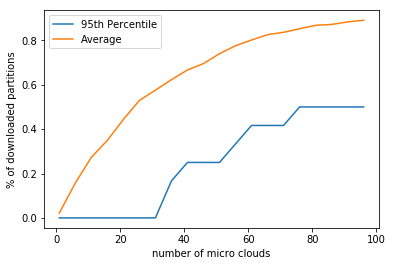

In [23]:
vp.plot_important(results_df)